In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from matplotlib import font_manager, rc
# Windows 예: 맑은 고딕
rc('font', family='Malgun Gothic')


# 한글 폰트 설정 확인
print(plt.rcParams['font.family'])

['Malgun Gothic']


In [14]:
df_movie_total = pd.read_excel('movie_finished_toFDA_변수설명.xlsx', sheet_name='데이터')
df_movie_총관객 = pd.read_excel('movie_finished_toFDA_변수설명.xlsx', sheet_name='총매출액')
df_movie_상영기간 = pd.read_csv('movie_term.csv', index_col=0, encoding='cp949')

# 데이터 전처리

## 총관객 데이터(영화상영기간 전체)

In [15]:
df_movie_총관객['영화명'] = df_movie_총관객['영화명'].astype(str)
df_movie_total['movie_title'] = df_movie_total['movie_title'].astype(str)

print((set(df_movie_total['movie_title']) - set(df_movie_총관객['영화명']))) # 제공받은 데이터와 총 관객 데이터 영화명 대조
df_movie_총관객 = df_movie_총관객[df_movie_총관객['영화명'].isin(list(set(df_movie_total['movie_title'])))].reset_index(drop=True) # 409개 영화에 대해 가져오기

# 영화명 단위로 데이터 추출 : 누적 관객수
aggregated_df = df_movie_총관객[df_movie_총관객['영화명'].duplicated(keep=False)].groupby(['영화명']).agg({
    '누적관객수 ': 'max', # 누적 관객수
}).reset_index()

# 중복된 데이터 제거 후 병합
df_concat_총매출 = pd.concat([df_movie_총관객[~df_movie_총관객['영화명'].duplicated(keep=False)][aggregated_df.columns], aggregated_df], axis=0).reset_index(drop=True)

set()


In [17]:
# 영화명 열을 기준으로 병합
df_movie_총기간 = pd.merge(df_concat_총매출, df_movie_상영기간, on='영화명', how='outer') 

### 파생변수
##### 첫날 상영횟수 : 배급사가 영화에 대해 기대하는 정도 - 즉, 영화 개봉 이전까지의 투자 정도
##### 흥행 : 투자 대비 소득 = 전체 소득/기대값(첫날 상영횟수)

In [18]:
# 상영 첫날 상영횟수

first_watch_dict = {}

for movie in set(df_movie_total['movie_title']):
    first_watch_dict[movie] = list(df_movie_total[df_movie_total['movie_title'] == movie]['상영횟수'])[0]

df_movie_총기간['첫날 상영수'] = df_movie_총기간['영화명'].map(first_watch_dict)
df_movie_총기간['수익성'] = df_movie_총기간['누적관객수 ']/df_movie_총기간['첫날 상영수'] # 흥행정도 = 누적관객수/첫날 스크린 수

# 클러스터링

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\2837579737.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["첫날 상영수(log)"] = np.log1p(df["첫날 상영수"])
C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\2837579737.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["상영기간(주)(log)"] = np.log1p(df["상영기간(주)"])
C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\2837579737.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

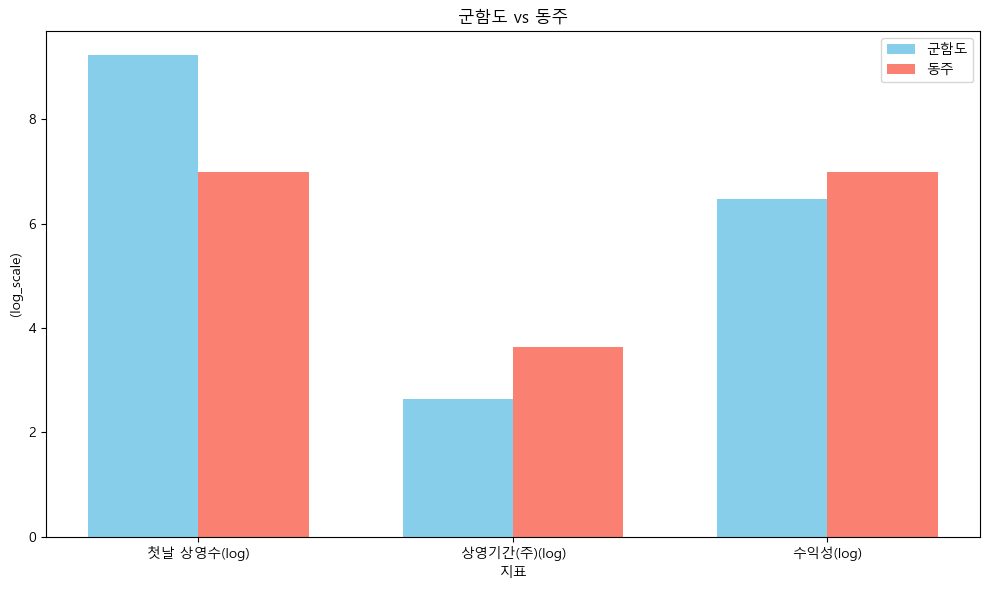

In [19]:
# 동주, 군함도 비교

df = df_movie_총기간[df_movie_총기간['영화명'].isin(['동주', '군함도'])]

# 로그 값 계산
df["첫날 상영수(log)"] = np.log1p(df["첫날 상영수"])
df["상영기간(주)(log)"] = np.log1p(df["상영기간(주)"])
df["수익성(log)"] = np.log1p(df["수익성"])

fig, ax = plt.subplots(figsize=(10, 6))
# x축 지표
metrics = ["첫날 상영수(log)", "상영기간(주)(log)", "수익성(log)"]
x = np.arange(len(metrics))  # 지표 위치

# 데이터 추출
values_gunhamdo = df[df['영화명'] == '군함도'][["첫날 상영수(log)", "상영기간(주)(log)", "수익성(log)"]].values.flatten()
values_dongju = df[df['영화명'] == '동주'][["첫날 상영수(log)", "상영기간(주)(log)", "수익성(log)"]].values.flatten()

# 막대 너비 설정
width = 0.35

# 막대 그래프 그리기
ax.bar(x - width / 2, values_gunhamdo, width, label="군함도", color="skyblue")
ax.bar(x + width / 2, values_dongju, width, label="동주", color="salmon")

# 그래프 꾸미기
ax.set_xlabel("지표")
ax.set_ylabel("(log_scale)")
ax.set_title("군함도 vs 동주")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

array([[<Axes: title={'center': '상영기간(주)'}>,
        <Axes: title={'center': '첫날 상영수'}>]], dtype=object)

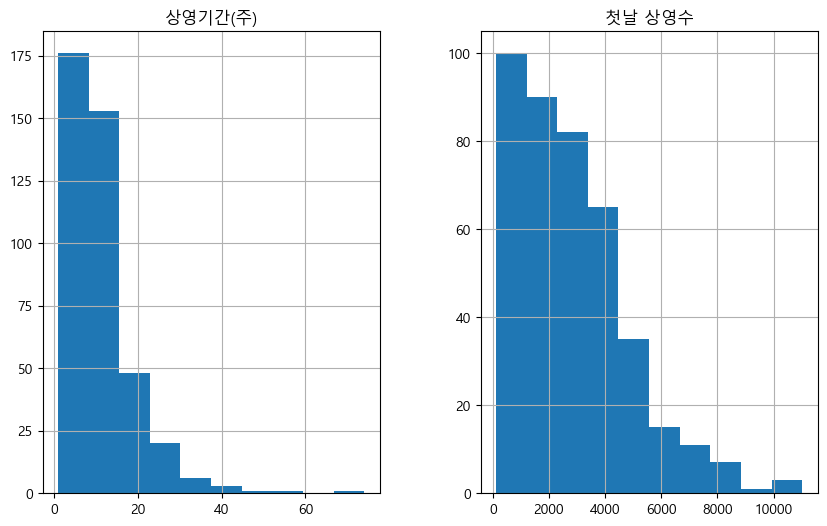

In [20]:
df_movie_총기간[['상영기간(주)', '첫날 상영수']].hist(figsize=(10, 6))

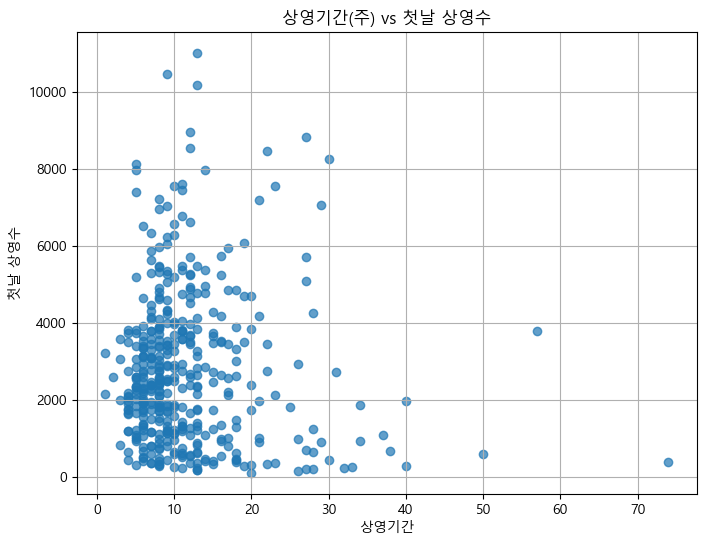

In [21]:
# 산점도 그리기
plt.figure(figsize=(8, 6))
plt.scatter(df_movie_총기간['상영기간(주)'], df_movie_총기간['첫날 상영수'], alpha=0.7)
plt.title('상영기간(주) vs 첫날 상영수')
plt.xlabel('상영기간')
plt.ylabel('첫날 상영수')
plt.grid(True)
plt.show()

In [22]:
df_movie_총기간["첫날 상영수(log)"] = np.log1p(df_movie_총기간["첫날 상영수"])

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 2. 필요한 열 선택 (상영기간과 첫날 상영수_log)
df_to_scale = df_movie_총기간[['상영기간(주)', '첫날 상영수(log)']]

# 3. 표준화 (Standardization)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_to_scale)

# 4. K-Means 클러스터링 (4개 클러스터)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# 5. 클러스터 결과를 원본 데이터에 추가
df_movie_총기간['Cluster_by_배급'] = clusters


c:\Users\cryst\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [24]:
df_movie_총기간['Cluster_by_배급'].value_counts()

Cluster_by_배급
1    202
0     98
2     88
3     21
Name: count, dtype: int64

c:\Users\cryst\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


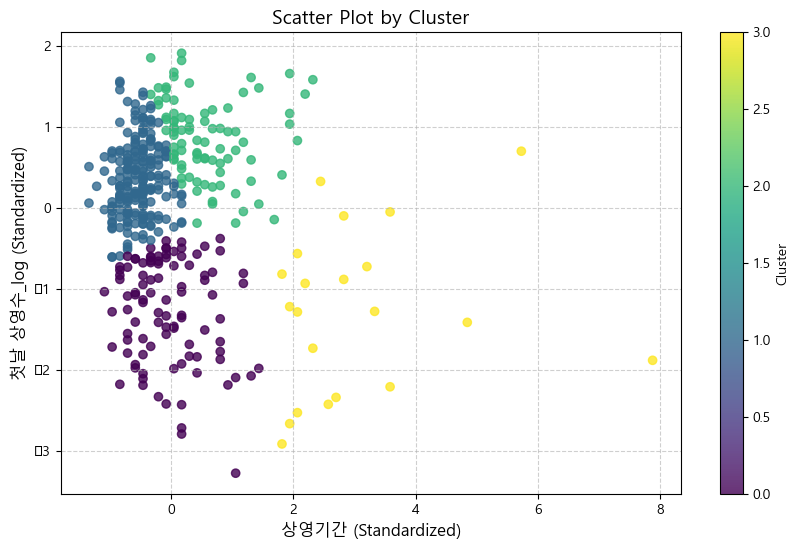

In [25]:
# Scaling : 표준화
scaler = StandardScaler()
df_movie_총기간[['상영기간(주)_scaled', '첫날 상영수(log)_scaled']] = scaler.fit_transform(
    df_movie_총기간[['상영기간(주)', '첫날 상영수(log)']]
)

# 시각화
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_movie_총기간['상영기간(주)_scaled'], df_movie_총기간['첫날 상영수(log)_scaled'],
    c=df_movie_총기간['Cluster_by_배급'], cmap='viridis', alpha=0.8
)

plt.colorbar(scatter, label='Cluster')
plt.title('Scatter Plot by Cluster', fontsize=14)
plt.xlabel('상영기간 (Standardized)', fontsize=12)
plt.ylabel('첫날 상영수_log (Standardized)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [26]:
df_movie_총기간.groupby('Cluster_by_배급')['수익성'].mean()

Cluster_by_배급
0    412.368029
1    332.485546
2    865.732897
3    702.438625
Name: 수익성, dtype: float64

In [27]:
# 영화명 확인

print(list(df_movie_총기간[df_movie_총기간['Cluster_by_배급'] == 0]['영화명']))
print(list(df_movie_총기간[df_movie_총기간['Cluster_by_배급'] == 1]['영화명']))
print(list(df_movie_총기간[df_movie_총기간['Cluster_by_배급'] == 2]['영화명']))
print(list(df_movie_총기간[df_movie_총기간['Cluster_by_배급'] == 3]['영화명']))

['0.0MHz', '12 솔져스', '50가지 그림자: 해방', '감바의 대모험', '고스트버스터즈', '공범자들', '그날, 바다', '그린치', '극장판 도라에몽: 진구의 보물섬', '극장판 소드 아트 온라인 -오디널 스케일-', '극장판 안녕 자두야', '극장판 요괴워치: 염라대왕과 5개의 이야기다냥!', '극장판 요괴워치: 하늘을 나는 고래와 더블세계다냥!', '극장판 짱구는 못말려 : 습격!! 외계인 덩덩이', '극장판 포켓몬스터 너로 정했다!', '극장판 포켓몬스터 모두의 이야기', '글로리데이', '나는 내일, 어제의 너와 만난다', '나미야 잡화점의 기적', '넛잡 2', '눈길', '다이버전트 시리즈: 얼리전트', '달빛궁궐', '당갈', '대니쉬 걸', '더 테이블', '더 페이버릿: 여왕의 여자', '더 포스트', '덤보', '드림 쏭', '라스트 미션', '러브 유어셀프 인 서울', '런닝맨 : 풀룰루의 역습', '레고 배트맨 무비', '레드 스패로', '레이디 버드', '루돌프와 많이있어', '마이펫 오지', '명탐정 코난:진홍의 연가', '목소리의 형태', '몬스터 패밀리', '문라이트', '미 비포 유', '미드나잇 선', '미래의 미라이', '미스컨덕트', '바이스', '발레리나', '부활', '빅쇼트', '빅풋 주니어', '뽀로로 극장판 보물섬 대모험', '서울역', '셰이프 오브 워터: 사랑의 모양', '스머프: 비밀의 숲', '시카리오: 데이 오브 솔다도', '신데렐라:마법 반지의 비밀', '신비아파트: 금빛 도깨비와 비밀의 동굴', '아기배달부 스토크', '아이 필 프리티', '아이스 에이지: 지구 대충돌', '안녕, 나의 소녀', '앨빈과 슈퍼밴드: 악동 어드벤처', '앵그리버드 더 무비', '언더독', '얼리맨', '업그레이드', '옥자', '원피스 필름 골드', '유전', '자백', '장난감이 살아있다', '장난스런 키스', '저수지 게임', '점박이 한반도의 공룡2 : 새로운 낙원', '제 5침공', '존 윅 - 리

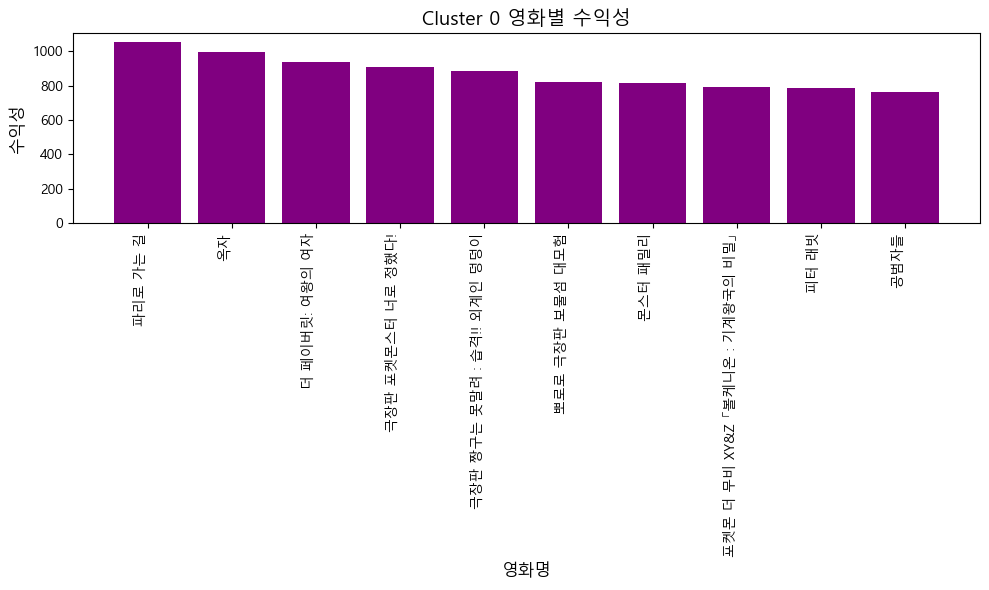

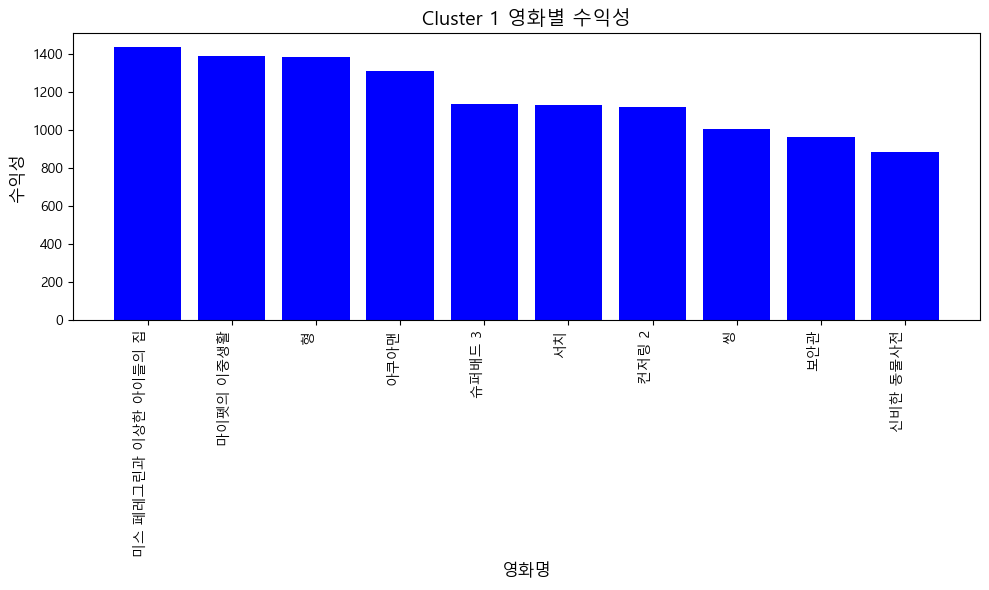

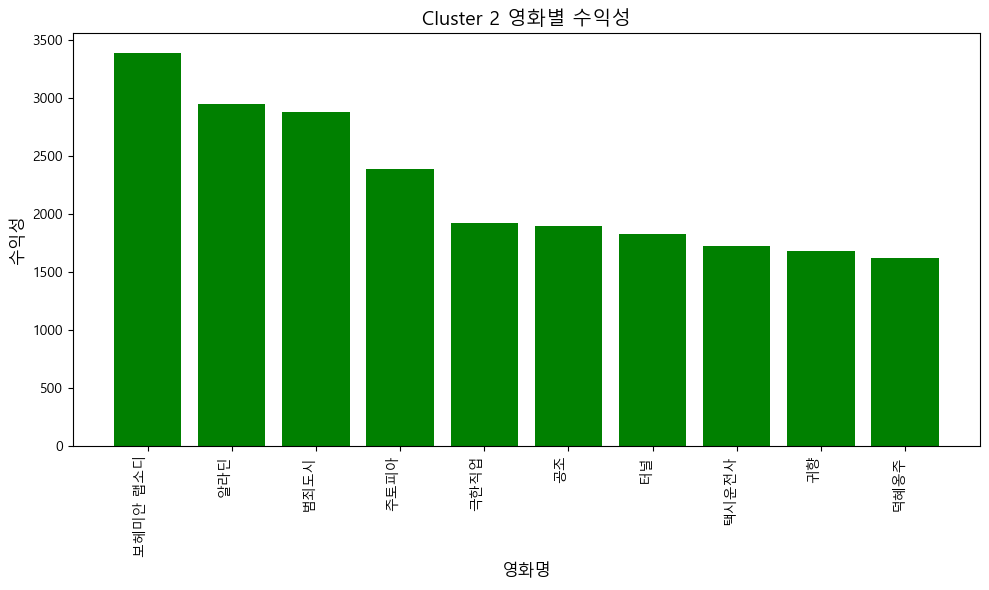

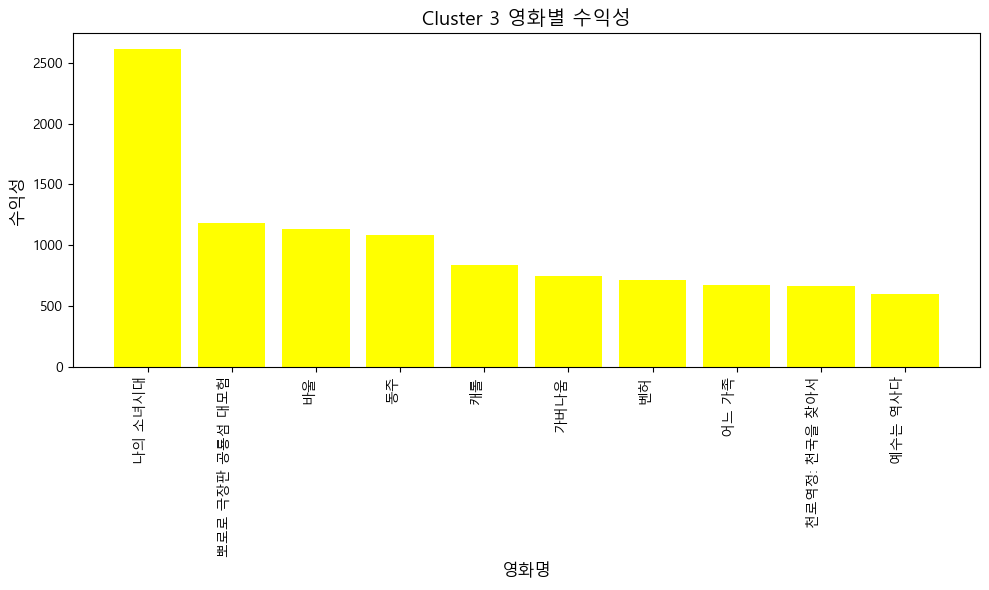

In [28]:
# 색상 설정
cluster_colors = {0: "purple", 1: "blue", 2: "green", 3: "yellow"}

# 클러스터별 그래프 생성
for cluster in [0, 1, 2, 3]:
    # 클러스터별 상위 10개 데이터 추출
    df_cluster = df_movie_총기간[df_movie_총기간['Cluster_by_배급'] == cluster][['영화명', '수익성']].sort_values(by="수익성", ascending=False).head(10)
    
    # 그래프 생성
    plt.figure(figsize=(10, 6))
    plt.bar(df_cluster["영화명"], df_cluster["수익성"], color=cluster_colors[cluster])
    plt.xlabel("영화명", fontsize=12)
    plt.ylabel("수익성", fontsize=12)
    plt.title(f"Cluster {cluster} 영화별 수익성", fontsize=14)
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

In [29]:
# 클러스터별 영화

cluster0 = list(df_movie_총기간[df_movie_총기간['Cluster_by_배급'] == 0]['영화명'])
cluster1 = list(df_movie_총기간[df_movie_총기간['Cluster_by_배급'] == 1]['영화명'])
cluster2 = list(df_movie_총기간[df_movie_총기간['Cluster_by_배급'] == 2]['영화명'])
cluster3 = list(df_movie_총기간[df_movie_총기간['Cluster_by_배급'] == 3]['영화명'])

# 데이터 전처리 for 회귀분석

In [30]:
print(df_movie_total.columns)
df_movie_total.head()

Index(['naver_movie_code', 'kobis_movie_code', 'movie_title', 'release_date',
       'DoW_release', 'Date', 'DoW', 'MoY', 'D_D', 'DailyTotal',
       ...
       '국적평균누적관객수', '국적평균스크린수', '등급평균관객수', '등급평균누적관람객수', '등급평균스크린수',
       '7days_before', '5days_before', 'Day_of_release', '5days_after',
       '7days_after'],
      dtype='object', length=172)


,naver_movie_code,kobis_movie_code,movie_title,release_date,DoW_release,Date,DoW,MoY,D_D,DailyTotal,...,국적평균누적관객수,국적평균스크린수,등급평균관객수,등급평균누적관람객수,등급평균스크린수,7days_before,5days_before,Day_of_release,5days_after,7days_after
0,107374,20142641,나를 잊지 말아요,42376,Thursday,42376,Thursday,January,0,612,...,859493,95,9090,596341,79,11,11,13,6,33
1,107374,20142641,나를 잊지 말아요,42376,Thursday,42377,Friday,January,1,332,...,859493,95,9090,596341,79,11,11,13,6,33
2,107374,20142641,나를 잊지 말아요,42376,Thursday,42378,Saturday,January,2,394,...,859493,95,9090,596341,79,11,11,13,6,33
3,107374,20142641,나를 잊지 말아요,42376,Thursday,42379,Sunday,January,3,205,...,859493,95,9090,596341,79,11,11,13,6,33
4,107374,20142641,나를 잊지 말아요,42376,Thursday,42380,Monday,January,4,246,...,859493,95,9090,596341,79,11,11,13,6,33


In [31]:
# 국적 처리 : 한국영화 1, 나머지 0
df_movie_total['nationality'] = df_movie_total['nationality'].apply(lambda x: '한국영화' if '한국' in x else '외국영화')

In [32]:
# 1주차 : 개봉 주 일요일 기준
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_movie_total['DoW_release'] = pd.Categorical(df_movie_total['DoW_release'], categories=day_order, ordered=True)

results = []
for movie, group in df_movie_total.groupby('movie_title'):
    # 첫 주 스크린 점유율
    first_sunday_idx = group[group['DoW_release'] == 'Sunday'].index.min()
    filtered_group = group.loc[:first_sunday_idx]
    avg_screen_share = filtered_group['스크린점유율'].mean()

    # 첫 주 실관람객 평균평점 = 입소문
    avg_daily_score = filtered_group['RV_Dailyscore'].mean()
    results.append({'movie_title': movie, '1주차스크린점유율': avg_screen_share, '1주차실관람객평균평점': avg_daily_score})

result_df = pd.DataFrame(results)
df_movie_total = df_movie_total.merge(result_df, on='movie_title', how='left')

In [33]:
# 1주차실관람객평균평점에 nan값 존재

null_count = df_movie_total.isnull().sum()
null_count[null_count.values > 0]

RV_Dailyscore             92
NTZ_Dailyscore            45
RV_neg_ratio              92
RV_neut_ratio             92
RV_pos_ratio              92
NTZ_neg_ratio             45
NTZ_neut_ratio            45
NTZ_pos_ratio             45
RV_Entropy                92
NTZ_Entropy               45
directors                 15
감독군                       15
directors_naver_code      15
제작사                     3510
제공                      3645
1주차실관람객평균평점               45
dtype: int64

In [34]:
# 1주차 실관람객 평균 평점 결측값 처리
df_movie_total['1주차실관람객평균평점'] = df_movie_total['1주차실관람객평균평점'].fillna(99999)
replace_dic = {'나의 소녀시대': 9.4, '업그레이드': 8.8, '러브 유어셀프 인 서울': 9.3}
for movie, score in replace_dic.items():
    df_movie_total.loc[df_movie_total['movie_title'] == movie, '1주차실관람객평균평점'] = score

In [35]:
null_count = df_movie_total.isnull().sum()
null_count[null_count.values > 0]

RV_Dailyscore             92
NTZ_Dailyscore            45
RV_neg_ratio              92
RV_neut_ratio             92
RV_pos_ratio              92
NTZ_neg_ratio             45
NTZ_neut_ratio            45
NTZ_pos_ratio             45
RV_Entropy                92
NTZ_Entropy               45
directors                 15
감독군                       15
directors_naver_code      15
제작사                     3510
제공                      3645
dtype: int64

In [36]:
# 경쟁 영화 수 계산 : 개봉 전,후 5~7일, 개봉 당일의 경쟁 영화 수 count 
df_movie_total['2주동안의 경쟁영화수'] = df_movie_total[['7days_before', '5days_before', 'Day_of_release', '5days_after', '7days_after']].sum(axis=1)

# 감독, 배우 로그 변환
log_columns = ['director_power', 'actor_power']
for col in log_columns:
    df_movie_total[col] = pd.to_numeric(df_movie_total[col], errors='coerce').fillna(0)
    df_movie_total[col] = np.log1p(df_movie_total[col])

In [37]:
col_genre = ['사극', 'SF', '어드벤처', '액션', '범죄', '판타지', '가족', '미스터리', '스릴러', '뮤지컬',
             '코미디', '공포(호러)', '애니메이션', '드라마', '서부극(웨스턴)', '전쟁', '멜로/로맨스', '기타',
             '다큐멘터리', '공연', '성인물(에로)']

df_genre = df_movie_total.groupby('movie_title')[col_genre].mean()
df_genre.drop(['기타', '성인물(에로)'],axis=1, inplace=True)


In [38]:
# 장르 묶음 : 제작비투입 많은 장르, 문화 스토리 분야의 장르, 감각적 경험이 강조된 장르, animation, 다큐멘터리
groupings = {
    '제작비 투입' : ['액션', 'SF', '판타지', '어드벤처', "서부극(웨스턴)", "사극", "전쟁"],
    "문화 스토리": ["드라마", "코미디", "멜로/로맨스", "뮤지컬", "가족", "공연"],
    "감각적 경험" : ["공포(호러)", "범죄", "스릴러", "미스터리"]
}

df_genre_update = pd.DataFrame()

all_grouped_cols = set(itertools.chain.from_iterable(groupings.values()))
remaining_cols = [col for col in df_genre.columns if col not in all_grouped_cols]

# groupings에 포함되지 않은 컬럼 추가
df_genre_update[remaining_cols] = df_genre[remaining_cols]


# 그룹별 컬럼을 묶는 작업
for new_col, old_cols in groupings.items():
    df_genre_update[new_col] = df_genre[old_cols].sum(axis=1)

df_genre_update[df_genre_update > 1] = 1

In [39]:
df = df_movie_total.copy()

# 사용할 변수 정의
col_movie_name = ['movie_title']
col_national = ['nationality']
col_direc_power = ['director_power']
col_watch_grade = ['watch_grade']
col_act_power = ['actor_power']
screen_col = ['1주차스크린점유율']
compete_col = ['2주동안의 경쟁영화수']
score_col = ['1주차실관람객평균평점']

# 모델 데이터 생성
df_modeling = df[col_movie_name + col_national + col_watch_grade + col_direc_power +
              col_act_power + screen_col + compete_col + score_col].copy()

# 더미 변수 생성
df_modeling = pd.get_dummies(df_modeling, columns=['nationality', 'watch_grade'], drop_first=True)

# 데이터 타입 변환
df_modeling.update(df_modeling.select_dtypes(include=['bool']).astype(int))

# 그룹화하여 영화별 평균 데이터 생성
df_modeling = df_modeling.groupby('movie_title').mean()

# 수익성 = log(최종 관객수/1일차 상영 횟수)
# 누적관객수 log씌우기

df_movie_총기간['누적관객수_log_scaled'] = np.log1p(df_movie_총기간['누적관객수 '])
df_movie_총기간['수익성'] = np.log1p(df_movie_총기간['수익성'])

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\472038423.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_modeling.update(df_modeling.select_dtypes(include=['bool']).astype(int))
C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\472038423.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_modeling.update(df_modeling.select_dtypes(include=['bool']).astype(int))
C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\472038423.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to 

In [40]:
# 클러스터링 데이터, 장르 데이터 병합

df_feature_cluster = df_movie_총기간[['영화명', '수익성', '첫날 상영수(log)', '상영기간(주)', 'Cluster_by_배급', '누적관객수_log_scaled']]
df_feature_cluster.set_index('영화명', inplace=True)  # '영화명'을 인덱스로 설정

df_model = pd.concat([df_modeling, df_genre_update, df_feature_cluster], axis=1)

In [41]:
# 컬럼명 변환

col_replace = {
    '1주차스크린점유율': 'ScreenShare1W',
    '2주동안의 경쟁영화수': 'CompMovies2W',
    '1주차실관람객평균평점': 'Score1W',
    'nationality_한국영화': 'KoreanMovie',
    'watch_grade_15세이상관람가': 'Grade15+',
    'watch_grade_전체관람가': 'GradeAll',
    'watch_grade_청소년관람불가': 'GradeR',
    '애니메이션': 'Animation',
    '다큐멘터리': 'Docu',
    '제작비 투입': 'HighBudget',
    '문화 스토리': 'Cultural',
    '감각적 경험': 'Sensory',
    '수익성': 'Profit',
    '첫날 상영수(log)': 'ScreensLog1D',
    '상영기간(주)': 'DurationW',
    'Cluster_by_배급': 'ClusterDist',
    '누적관객수_log_scaled' : 'Audience_Log1D'
}

df_model = df_model.rename(columns=col_replace)
df_genre_update = df_genre_update.rename(columns=col_replace)


# 클러스터별 회귀분석

In [42]:
# 변수 선택 과정을 수행하는 함수
def processSubset(X, y, feature_set):
    model = sm.OLS(y, sm.add_constant(X[list(feature_set)]))
    regression = model.fit()
    return {"model": regression, "AIC": regression.aic}

# 후진제거법
def backward(X, y, predictors, fixed_columns):
    results = []
    # 고정 컬럼 포함한 조합 생성
    max_combo_size = max(len(predictors) - len(fixed_columns) - 1, 0)  # r 값이 음수가 되지 않도록 보장
    for combo in itertools.combinations(
        [p for p in predictors if p not in fixed_columns], max_combo_size
    ):
        full_combo = list(combo) + fixed_columns
        results.append(processSubset(X, y, full_combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['AIC'].idxmin()]
    return best_model

# 고정 피처 포함 후진제거법
def backward_model(X, y, fixed_columns=None):
    if fixed_columns is None:
        fixed_columns = []
    predictors = [col for col in X.columns if col not in fixed_columns]

    # 입력값 검증: 모든 피처가 고정되었거나 남은 변수가 없는 경우 방지
    if len(predictors) < 1 and len(fixed_columns) > 0:
        raise ValueError("No selectable predictors left after excluding fixed columns.")
    
    Bmodels = pd.DataFrame(columns=["AIC", "model"], index=range(len(predictors) + len(fixed_columns)))

    while len(predictors) > 0:
        current_model = backward(X, y, predictors, fixed_columns)
        Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model
        predictors = current_model['model'].model.exog_names
        predictors = [p for p in predictors if p != 'const' and p not in fixed_columns]

    # 최적의 모델 추출
    best_model_index = Bmodels['AIC'].idxmin()
    best_model = Bmodels.loc[best_model_index]
    return best_model


In [43]:
# 크러스터별 영화 묶기

df_cluster0 = df_model[df_model.index.isin(cluster0)]
df_cluster1 = df_model[df_model.index.isin(cluster1)]
df_cluster2 = df_model[df_model.index.isin(cluster2)]
df_cluster3 = df_model[df_model.index.isin(cluster3)]

In [44]:
df_movie_총기간.groupby('Cluster_by_배급').size()

Cluster_by_배급
0     98
1    202
2     88
3     21
dtype: int64

### 영화 데이터 전체 회귀분석

In [45]:
df_model_total = df_model.copy()

# 독립변수(X)와 종속변수(y) 설정
X = df_model_total.drop(['Audience_Log1D', 'Profit', 'ClusterDist', 'DurationW', 'ScreensLog1D'], axis=1)
y = df_model_total['Audience_Log1D']

# 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)
# 최소 독립변수 개수
final_model = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

final_model['model'].summary()

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\780170681.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Audience_Log1D   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     269.5
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          6.76e-156
Time:                        13:05:17   Log-Likelihood:                -279.06
No. Observations:                 409   AIC:                             576.1
Df Residuals:                     400   BIC:                             612.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.7284      0.261     41.080      0.000      10.215      11.242
ScreenShare1W    18.1312      0.419     43.230      0.000      17.307      18.956
CompMovies2W     -0.0013      0.001     -1.089      0.277      -0.004       0.001
Score1W           0.1147      0.026      4.397      0.000       0.063       0.166
Animation         0.0668      0.074      0.906      0.365      -0.078       0.212
Docu             -0.1274      0.214     -0.596      0.551      -0.547       0.293
HighBudget        0.0504      0.053      0.948      0.344      -0.054       0.155
Cultural          0.0993      0.058      1.713      0.087      -0.015       0.213
Sensory           0.1442      0.063      2.290      0.023       0.020       0.268
==============================================================================
Omnibus:                        9.240   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               14.676
Skew:                          -0.114   Prob(JB):                     0.000650
Kurtosis:                       3.900   Cond. No.                     1.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# 종속변수를 수익성으로 변경
y = df_model_total['Profit']

# 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)
final_model_profit = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

final_model_profit['model'].summary()

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\780170681.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     50.22
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           7.06e-56
Time:                        13:05:17   Log-Likelihood:                -349.31
No. Observations:                 409   AIC:                             716.6
Df Residuals:                     400   BIC:                             752.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.1026      0.310     10.005      0.000       2.493       3.712
ScreenShare1W     7.2516      0.498     14.561      0.000       6.273       8.231
CompMovies2W     -0.0030      0.001     -2.209      0.028      -0.006      -0.000
Score1W           0.2690      0.031      8.689      0.000       0.208       0.330
Animation         0.5840      0.088      6.669      0.000       0.412       0.756
Docu              0.4584      0.254      1.808      0.071      -0.040       0.957
HighBudget       -0.0560      0.063     -0.886      0.376      -0.180       0.068
Cultural          0.1176      0.069      1.708      0.088      -0.018       0.253
Sensory           0.0598      0.075      0.801      0.424      -0.087       0.207
==============================================================================
Omnibus:                        9.019   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.363
Skew:                           0.300   Prob(JB):                      0.00926
Kurtosis:                       3.434   Cond. No.                     1.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 클러스터0 영화 데이터 회귀분석

In [47]:
# 데이터 준비
df_model0 = df_cluster0

# 독립변수(X)와 종속변수(y) 설정
X = df_model0.drop(['Audience_Log1D', 'Profit', 'ClusterDist', 'DurationW', 'ScreensLog1D'], axis=1)
y = df_model0['Audience_Log1D']

# 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)
# 최소 독립변수 개수
final_model = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

final_model['model'].summary()

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\780170681.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Audience_Log1D   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     18.86
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           2.98e-16
Time:                        13:05:17   Log-Likelihood:                -36.898
No. Observations:                  98   AIC:                             91.80
Df Residuals:                      89   BIC:                             115.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.6323      0.221     52.698      0.000      11.194      12.071
actor_power      -0.0243      0.014     -1.786      0.078      -0.051       0.003
ScreenShare1W    22.1880      2.155     10.298      0.000      17.907      26.469
Grade15+         -0.2833      0.106     -2.674      0.009      -0.494      -0.073
Animation        -0.0292      0.109     -0.268      0.790      -0.246       0.187
Docu              0.1364      0.244      0.558      0.578      -0.349       0.622
HighBudget        0.0462      0.080      0.577      0.566      -0.113       0.206
Cultural          0.1277      0.093      1.368      0.175      -0.058       0.313
Sensory          -0.0322      0.147     -0.219      0.827      -0.324       0.260
==============================================================================
Omnibus:                        1.710   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                1.733
Skew:                           0.263   Prob(JB):                        0.421
Kurtosis:                       2.617   Cond. No.                         865.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# 종속변수를 수익성으로 변경
y = df_model0['Profit']

# 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)
final_model_profit = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

final_model_profit['model'].summary()

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\780170681.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     7.786
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           7.18e-08
Time:                        13:05:17   Log-Likelihood:                -70.608
No. Observations:                  98   AIC:                             159.2
Df Residuals:                      89   BIC:                             182.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.0012      0.557      8.982      0.000       3.895       6.108
Score1W         0.0822      0.065      1.266      0.209      -0.047       0.211
KoreanMovie    -0.1919      0.143     -1.339      0.184      -0.477       0.093
Grade15+       -0.5533      0.151     -3.672      0.000      -0.853      -0.254
Animation       0.4684      0.145      3.226      0.002       0.180       0.757
Docu            1.0767      0.352      3.060      0.003       0.378       1.776
HighBudget     -0.0602      0.115     -0.523      0.602      -0.289       0.169
Cultural        0.1756      0.136      1.289      0.201      -0.095       0.446
Sensory        -0.0572      0.210     -0.272      0.786      -0.475       0.361
==============================================================================
Omnibus:                        1.238   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.538   Jarque-Bera (JB):                0.723
Skew:                           0.045   Prob(JB):                        0.697
Kurtosis:                       3.411   Cond. No.                         95.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 클러스터1 영화 데이터 회귀분석

In [49]:
# 데이터 준비
df_model1 = df_cluster1

# 독립변수(X)와 종속변수(y) 설정
X = df_model1.drop(['Audience_Log1D', 'Profit', 'ClusterDist', 'DurationW', 'ScreensLog1D'], axis=1)
y = df_model1['Audience_Log1D']

# # 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)  # 최소 독립변수 개수
# final_model = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

# final_model['model'].summary()

X = sm.add_constant(X)

# 모델 생성 및 피팅
model = sm.OLS(y, X)
results = model.fit()

# 결과 요약 출력
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Audience_Log1D   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     62.15
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           8.20e-61
Time:                        13:05:17   Log-Likelihood:                -102.63
No. Observations:                 202   AIC:                             233.3
Df Residuals:                     188   BIC:                             279.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.0957      0.370     29.974      0.000      10.365      11.826
director_power    -0.0027      0.005     -0.537      0.592      -0.013       0.007
actor_power        0.0215      0.012      1.816      0.071      -0.002       0.045
ScreenShare1W     19.1956      0.762     25.205      0.000      17.693      20.698
CompMovies2W      -0.0029      0.001     -2.102      0.037      -0.006      -0.000
Score1W            0.0529      0.032      1.645      0.102      -0.011       0.116
KoreanMovie       -0.1087      0.080     -1.353      0.178      -0.267       0.050
Grade15+           0.0151      0.078      0.194      0.847      -0.139       0.169
GradeAll          -0.0834      0.181     -0.461      0.645      -0.440       0.273
GradeR            -0.0639      0.112     -0.570      0.570      -0.285       0.157
Animation          0.5447      0.242      2.251      0.026       0.067       1.022
Docu            7.447e-17   1.59e-17      4.689      0.000    4.31e-17    1.06e-16
HighBudget        -0.0208      0.078     -0.268      0.789      -0.174       0.132
Cultural           0.0056      0.075      0.075      0.940      -0.143       0.154
Sensory            0.1488      0.077      1.927      0.056      -0.004       0.301
==============================================================================
Omnibus:                       28.197   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.302
Skew:                          -0.693   Prob(JB):                     1.62e-12
Kurtosis:                       5.128   Cond. No.                     3.80e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.75e-35. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [50]:
# 종속변수를 수익성으로 변경
y = df_model1['Profit']

# 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)
final_model_profit = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

# 결과 출력
final_model_profit['model'].summary()

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\780170681.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     39.16
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           1.48e-36
Time:                        13:05:18   Log-Likelihood:                -128.11
No. Observations:                 202   AIC:                             274.2
Df Residuals:                     193   BIC:                             304.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.4327      0.370      9.287      0.000       2.704       4.162
ScreenShare1W    11.9959      0.823     14.576      0.000      10.373      13.619
CompMovies2W     -0.0034      0.002     -2.239      0.026      -0.006      -0.000
Score1W           0.1618      0.035      4.660      0.000       0.093       0.230
KoreanMovie      -0.1512      0.078     -1.928      0.055      -0.306       0.003
Animation         0.7795      0.189      4.121      0.000       0.406       1.153
Docu          -8.574e-15   5.96e-16    -14.396      0.000   -9.75e-15    -7.4e-15
HighBudget       -0.1021      0.085     -1.208      0.228      -0.269       0.065
Cultural          0.0568      0.084      0.680      0.497      -0.108       0.222
Sensory           0.1736      0.079      2.191      0.030       0.017       0.330
==============================================================================
Omnibus:                        1.958   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.376   Jarque-Bera (JB):                1.593
Skew:                          -0.144   Prob(JB):                        0.451
Kurtosis:                       3.326   Cond. No.                     4.07e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.49e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 클러스터2 영화 데이터 회귀분석

In [51]:
# 데이터 준비
df_model2 = df_cluster2

# 독립변수(X)와 종속변수(y) 설정
X = df_model2.drop(['Audience_Log1D', 'Profit', 'ClusterDist', 'DurationW', 'ScreensLog1D'], axis=1)
y = df_model2['Audience_Log1D']

# 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)
final_model = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

final_model['model'].summary()

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\780170681.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Audience_Log1D   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     21.70
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           4.61e-17
Time:                        13:05:18   Log-Likelihood:                -56.968
No. Observations:                  88   AIC:                             131.9
Df Residuals:                      79   BIC:                             154.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.4172      0.785     13.278      0.000       8.856      11.979
ScreenShare1W    10.9292      0.939     11.636      0.000       9.060      12.799
Score1W           0.2479      0.086      2.871      0.005       0.076       0.420
KoreanMovie       0.2808      0.141      1.992      0.050       0.000       0.561
Animation         0.1803      0.183      0.984      0.328      -0.184       0.545
Docu              0.0182      0.519      0.035      0.972      -1.015       1.051
HighBudget        0.2989      0.131      2.290      0.025       0.039       0.559
Cultural          0.2009      0.127      1.583      0.117      -0.052       0.454
Sensory           0.1373      0.145      0.946      0.347      -0.152       0.426
==============================================================================
Omnibus:                        2.286   Durbin-Watson:                   2.231
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.826
Skew:                           0.096   Prob(JB):                        0.401
Kurtosis:                       3.679   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# 종속변수를 수익성으로 변경
y = df_model2['Profit']

# 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)
final_model_profit = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

final_model_profit['model'].summary()

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\780170681.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     5.530
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           1.48e-05
Time:                        13:05:18   Log-Likelihood:                -67.081
No. Observations:                  88   AIC:                             152.2
Df Residuals:                      79   BIC:                             174.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.1593      0.880      2.453      0.016       0.408       3.911
ScreenShare1W     4.7588      1.054      4.517      0.000       2.662       6.856
Score1W           0.3583      0.097      3.698      0.000       0.165       0.551
KoreanMovie       0.3654      0.158      2.311      0.023       0.051       0.680
Animation         0.2488      0.206      1.210      0.230      -0.160       0.658
Docu             -0.0291      0.582     -0.050      0.960      -1.188       1.130
HighBudget        0.1954      0.146      1.335      0.186      -0.096       0.487
Cultural          0.1364      0.142      0.958      0.341      -0.147       0.420
Sensory           0.1504      0.163      0.924      0.358      -0.174       0.474
==============================================================================
Omnibus:                        6.832   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.994
Skew:                           0.459   Prob(JB):                       0.0303
Kurtosis:                       4.032   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 클러스터3 영화 데이터 회귀분석

In [53]:
# 데이터 준비
df_model3 = df_cluster3

# 독립변수(X)와 종속변수(y) 설정
X = df_model3.drop(['Audience_Log1D', 'Profit', 'ClusterDist', 'DurationW', 'ScreensLog1D'], axis=1)
y = df_model3['Audience_Log1D']

# 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)
final_model = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

final_model['model'].summary()

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\780170681.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Audience_Log1D   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     27.49
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           8.18e-07
Time:                        13:05:19   Log-Likelihood:                 6.4060
No. Observations:                  21   AIC:                             3.188
Df Residuals:                      13   BIC:                             11.54
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.8475      0.119     74.516      0.000       8.591       9.104
actor_power      -0.0290      0.010     -2.769      0.016      -0.052      -0.006
ScreenShare1W    26.5009      2.509     10.563      0.000      21.081      31.921
Grade15+         -0.1667      0.130     -1.285      0.221      -0.447       0.114
Animation         2.9639      0.129     22.942      0.000       2.685       3.243
Docu              2.7089      0.191     14.199      0.000       2.297       3.121
HighBudget       -0.3635      0.193     -1.888      0.082      -0.779       0.053
Cultural          3.1747      0.093     34.217      0.000       2.974       3.375
Sensory          -0.2313      0.205     -1.129      0.279      -0.674       0.211
==============================================================================
Omnibus:                        3.586   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                2.475
Skew:                          -0.674   Prob(JB):                        0.290
Kurtosis:                       1.993   Cond. No.                     1.30e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.35e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [54]:
# 종속변수를 수익성으로 변경
y = df_model3['Profit']

# 후진 제거법으로 최적 모델 탐색 (최소 변수 개수 제한)
final_model_profit = backward_model(X, y, fixed_columns = list(df_genre_update.columns))

final_model_profit['model'].summary()

C:\Users\cryst\AppData\Local\Temp\ipykernel_12584\780170681.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Bmodels.loc[len(predictors) + len(fixed_columns)] = current_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     1.592
Date:                Fri, 13 Dec 2024   Prob (F-statistic):              0.223
Time:                        13:05:19   Log-Likelihood:                -10.710
No. Observations:                  21   AIC:                             37.42
Df Residuals:                      13   BIC:                             45.78
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.6430      0.563     10.026      0.000       4.427       6.859
director_power    -0.0370      0.022     -1.710      0.111      -0.084       0.010
CompMovies2W      -0.0111      0.007     -1.572      0.140      -0.026       0.004
Grade15+           0.6720      0.310      2.169      0.049       0.003       1.341
Animation          2.0397      0.384      5.305      0.000       1.209       2.870
Docu               1.6889      0.408      4.138      0.001       0.807       2.571
HighBudget         0.2741      0.373      0.734      0.476      -0.532       1.081
Cultural           1.9143      0.267      7.173      0.000       1.338       2.491
Sensory           -0.9162      0.427     -2.143      0.052      -1.840       0.007
==============================================================================
Omnibus:                        0.603   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.740   Jarque-Bera (JB):                0.081
Skew:                          -0.145   Prob(JB):                        0.961
Kurtosis:                       3.092   Cond. No.                     1.49e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.06e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""